IMPORT DATA

In [40]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [31]:
# **1. Load Dataset**
data = pd.read_csv('winequality-white.csv', delimiter=';')
print("Dataset Loaded Successfully")

Dataset Loaded Successfully


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None

Statistik Deskriptif:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count   

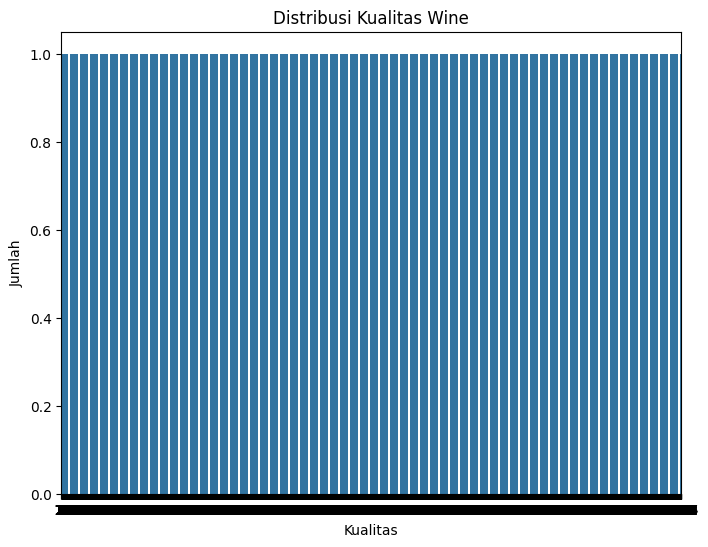

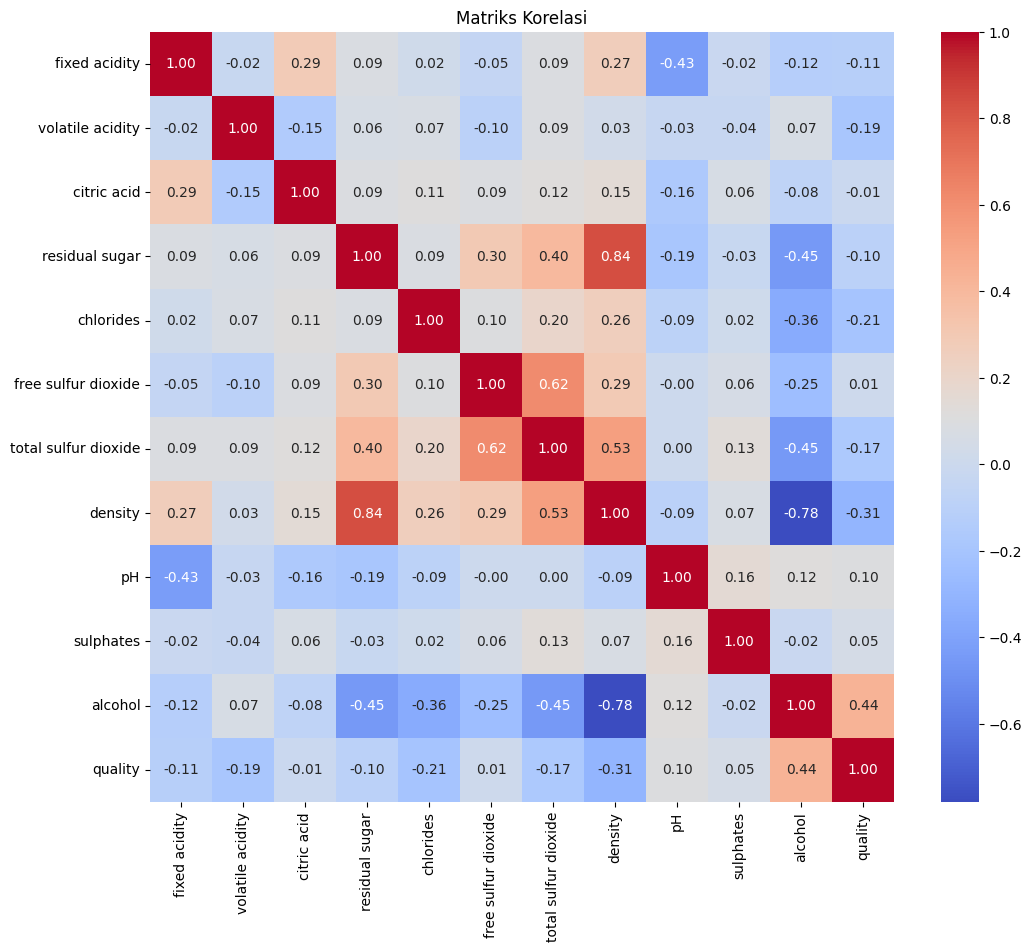

In [32]:
# Bagian 2: Exploratory Data Analysis (EDA)
# Membaca dataset
data = pd.read_csv('winequality-white.csv', delimiter=';')

# Menampilkan informasi dataset
print("Informasi Dataset:")
print(data.info())

# Statistik dasar dataset
print("\nStatistik Deskriptif:")
print(data.describe())

# Visualisasi distribusi kualitas
plt.figure(figsize=(8, 6))
sns.countplot(data['quality'])
plt.title("Distribusi Kualitas Wine")
plt.xlabel("Kualitas")
plt.ylabel("Jumlah")
plt.show()

# Visualisasi korelasi antar fitur
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

In [33]:
# Menggunakan hanya sebagian dataset (20% dari total data)
subset_ratio = 0.5
data = data.sample(frac=subset_ratio, random_state=42)


In [42]:
# Preprocessing data
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Normalisasi fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalisasi label
y = y - y.min()  # Pastikan label dimulai dari 0
output_size = len(set(y))  # Jumlah kelas unik

# Konversi data ke Tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Membagi data menjadi train dan validation set
train_size = int(0.8 * len(X_tensor))
val_size = len(X_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_tensor, y_tensor), [train_size, val_size])


In [43]:
# Fungsi untuk membangun model MLP
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_func):
        super(MLPModel, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(current_size, hidden_size))
            if activation_func == 'relu':
                layers.append(nn.ReLU())
            elif activation_func == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_func == 'tanh':
                layers.append(nn.Tanh())
            elif activation_func == 'softmax':
                layers.append(nn.Softmax(dim=1))
            elif activation_func == 'linear':
                pass  # Tidak menambahkan fungsi aktivasi
            current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))  # Output layer disesuaikan
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [46]:
# Parameter eksperimen
hidden_layer_configs = [
    [4], [8],  # Single hidden layer
    [4, 8], [16, 32],  # Two hidden layers
    [4, 8, 16], [16, 32, 64],  # Three hidden layers
]
activation_functions = [nn.ReLU, nn.Sigmoid, nn.Tanh, lambda: nn.Softmax(dim=1)]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
epochs_list = [ 10, 50, 100]

# Menyimpan hasil eksperimen
results = []
best_results = {activation: {'best_params': None, 'best_mse': float('inf')} for activation in activation_funcs}

In [ ]:
# Melakukan eksperimen
for hidden_layers, activation_func, epochs, lr, batch_size in itertools.product(hidden_layer_configs, activation_funcs, epochs_list, learning_rates, batch_sizes):
    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = MLPModel(input_size=X.shape[1], hidden_layers=hidden_layers, activation_func=activation_func)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluasi
    model.eval()
    val_predictions = []
    val_targets = []
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            outputs = model(val_X)
            val_loss += criterion(outputs, val_y).item()
            _, preds = torch.max(outputs, 1)
            val_predictions.extend(preds.numpy())
            val_targets.extend(val_y.numpy())

    # Menghitung metrik
    mse = val_loss / len(val_loader)
    accuracy = accuracy_score(val_targets, val_predictions) * 100

    # Output realtime
    print(f"Batch Size: {batch_size}, Hidden Layers: {hidden_layers}, Activation: {activation_func}, "
          f"LR: {lr}, Epochs: {epochs}, Validation Loss (MSE): {mse:.4f}, Accuracy: {accuracy:.2f}%")

    # Simpan hasil
    results.append({
        'hidden_layers': hidden_layers,
        'activation_func': activation_func,
        'epochs': epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'validation_loss': mse,
        'accuracy': accuracy
    })

    # Update hasil terbaik berdasarkan fungsi aktivasi
    if mse < best_results[activation_func]['best_mse']:
        best_results[activation_func]['best_mse'] = mse
        best_results[activation_func]['best_params'] = {
            'hidden_layers': hidden_layers,
            'epochs': epochs,
            'learning_rate': lr,
            'batch_size': batch_size
        }



Batch Size: 16, Hidden Layers: [4], Activation: relu, LR: 0.1, Epochs: 10, Validation Loss (MSE): 1.1692, Accuracy: 46.33%
Batch Size: 32, Hidden Layers: [4], Activation: relu, LR: 0.1, Epochs: 10, Validation Loss (MSE): 1.1122, Accuracy: 53.27%
Batch Size: 64, Hidden Layers: [4], Activation: relu, LR: 0.1, Epochs: 10, Validation Loss (MSE): 1.0204, Accuracy: 55.92%
Batch Size: 16, Hidden Layers: [4], Activation: relu, LR: 0.01, Epochs: 10, Validation Loss (MSE): 1.0289, Accuracy: 55.51%
Batch Size: 32, Hidden Layers: [4], Activation: relu, LR: 0.01, Epochs: 10, Validation Loss (MSE): 1.0489, Accuracy: 54.49%
Batch Size: 64, Hidden Layers: [4], Activation: relu, LR: 0.01, Epochs: 10, Validation Loss (MSE): 1.0543, Accuracy: 55.31%
Batch Size: 16, Hidden Layers: [4], Activation: relu, LR: 0.001, Epochs: 10, Validation Loss (MSE): 1.2206, Accuracy: 51.84%
Batch Size: 32, Hidden Layers: [4], Activation: relu, LR: 0.001, Epochs: 10, Validation Loss (MSE): 1.2282, Accuracy: 54.08%
Batch Siz

ModuleNotFoundError: No module named 'ace_tools'

In [48]:


# Menampilkan Hyperparameter Terbaik
print("\nHyperparameter Terbaik Berdasarkan Fungsi Aktivasi:")
for activation_fn, details in best_results.items():
    print(f"Activation Function: {activation_fn}")
    print(f"Best Parameters: {details['best_params']}")
    print(f"Best MSE: {details['best_mse']:.4f}\n")


Hyperparameter Terbaik Berdasarkan Fungsi Aktivasi:
Activation Function: relu
Best Parameters: {'hidden_layers': [16, 32, 64], 'epochs': 10, 'learning_rate': 0.01, 'batch_size': 64}
Best MSE: 0.9899

Activation Function: sigmoid
Best Parameters: {'hidden_layers': [16, 32], 'epochs': 50, 'learning_rate': 0.01, 'batch_size': 32}
Best MSE: 0.9790

Activation Function: tanh
Best Parameters: {'hidden_layers': [16, 32], 'epochs': 100, 'learning_rate': 0.001, 'batch_size': 32}
Best MSE: 0.9887

Activation Function: linear
Best Parameters: {'hidden_layers': [16, 32], 'epochs': 100, 'learning_rate': 0.1, 'batch_size': 64}
Best MSE: 1.0607

Activation Function: softmax
Best Parameters: {'hidden_layers': [8], 'epochs': 50, 'learning_rate': 0.01, 'batch_size': 64}
Best MSE: 0.9822

